In [33]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import ast
from pathlib import Path

## Step 1: Load the Data

In [34]:
# --- Load the Data with Error Handling ---
file_path = Path('data/videos_featured.csv')
if file_path.exists():
    df = pd.read_csv(file_path, sep=';')
    print(f"Data loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
else:
    raise FileNotFoundError("Dataset not found. Please check the path.")

Data loaded successfully: 366 rows, 17 columns


## Step 2: Initial Overview

In [45]:
print("\nBasic Info:") # Check nulls + types
df.info()

df.head() # View first 5 rows


Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   video_id               366 non-null    object 
 1   title                  366 non-null    object 
 2   published_at           366 non-null    object 
 3   views                  366 non-null    int64  
 4   likes                  366 non-null    int64  
 5   comments               366 non-null    int64  
 6   tags                   366 non-null    object 
 7   duration_seconds       366 non-null    int64  
 8   published_us_est       366 non-null    object 
 9   published_year         366 non-null    int64  
 10  published_month        366 non-null    int64  
 11  published_quarter      366 non-null    object 
 12  published_weekday      366 non-null    object 
 13  published_hour         366 non-null    int64  
 14  like_ratio             366 non-null    float6

,video_id,title,published_at,views,likes,comments,tags,duration_seconds,published_us_est,published_year,published_month,published_quarter,published_weekday,published_hour,like_ratio,comment_ratio,published_time_of_day
0,FGC0cCAgGu0,Twitter making me tear up over here 🥹,2024-02-23 13:34:27,7502,305,12,[],16,2024-02-23 08:34:27,2024,2,Q1,Friday,8,0.0407,0.0016,Morning
1,UOBTLzWY1vs,#DataAnalyst #AnalystBuilder #SQL,2024-03-01 13:43:29,21921,1515,20,[],38,2024-03-01 08:43:29,2024,3,Q1,Friday,8,0.0691,0.0009,Morning
2,k8nBWL6K884,What is Healthcare Analytics?,2025-02-18 13:01:11,26399,1303,79,"['Data Analyst', 'Data Analyst job', 'Data Ana...",656,2025-02-18 08:01:11,2025,2,Q1,Tuesday,8,0.0494,0.0030,Morning
3,r5512UY3MTc,1 Million Subscriber Livestream!! Giveaways + ...,2025-03-05 17:07:10,10268,675,68,"['Data Analyst', 'Data Analyst job', 'Data Ana...",6014,2025-03-05 12:07:10,2025,3,Q1,Wednesday,12,0.0657,0.0066,Afternoon
4,XuOcmjIbFGg,"Taking a look at Real Healthcare Data | ICD11,...",2025-03-04 13:00:44,8534,402,27,"['Data Analyst', 'Data Analyst job', 'Data Ana...",916,2025-03-04 08:00:44,2025,3,Q1,Tuesday,8,0.0471,0.0032,Morning


## Step 3: Data Processing

### Metrics Normalization

In [10]:
# Convert all date time to UTC time zone
df['published_at'] = pd.to_datetime(df['published_at'], utc=True)
extract_day = pd.Timestamp('2025-06-19', tz='UTC') # The day that videos are extracted is 2025-06-19

# Normalize metrics
df['days_since_publish'] = (extract_day - df['published_at']).dt.days.clip(lower=1) # type: ignore # ensure the minimal day is 1
df['views_per_day'] = np.ceil(df['views']/df['days_since_publish'])
df['likes_per_day'] = np.ceil(df['likes']/df['days_since_publish'])

### Binning Video Length

In [11]:
# Label duration buckets
df['duration_bucket'] = pd.cut(df['duration_seconds'], 
    bins=[0, 600, 1800, 3600, 100000],
    labels=['Short', 'Medium', 'Long', 'Very Long']
)

In [12]:
df.head() # Check normalized data

,video_id,title,published_at,views,likes,comments,tags,duration_seconds,published_us_est,published_year,...,published_quarter,published_weekday,published_hour,like_ratio,comment_ratio,published_time_of_day,days_since_publish,views_per_day,likes_per_day,duration_bucket
0,FGC0cCAgGu0,Twitter making me tear up over here 🥹,2024-02-23 13:34:27+00:00,7502,305,12,[],16,2024-02-23 08:34:27,2024,...,Q1,Friday,8,0.0407,0.0016,Morning,481,16.0,1.0,Short
1,UOBTLzWY1vs,#DataAnalyst #AnalystBuilder #SQL,2024-03-01 13:43:29+00:00,21921,1515,20,[],38,2024-03-01 08:43:29,2024,...,Q1,Friday,8,0.0691,0.0009,Morning,474,47.0,4.0,Short
2,k8nBWL6K884,What is Healthcare Analytics?,2025-02-18 13:01:11+00:00,26399,1303,79,"['Data Analyst', 'Data Analyst job', 'Data Ana...",656,2025-02-18 08:01:11,2025,...,Q1,Tuesday,8,0.0494,0.0030,Morning,120,220.0,11.0,Medium
3,r5512UY3MTc,1 Million Subscriber Livestream!! Giveaways + ...,2025-03-05 17:07:10+00:00,10268,675,68,"['Data Analyst', 'Data Analyst job', 'Data Ana...",6014,2025-03-05 12:07:10,2025,...,Q1,Wednesday,12,0.0657,0.0066,Afternoon,105,98.0,7.0,Very Long
4,XuOcmjIbFGg,"Taking a look at Real Healthcare Data | ICD11,...",2025-03-04 13:00:44+00:00,8534,402,27,"['Data Analyst', 'Data Analyst job', 'Data Ana...",916,2025-03-04 08:00:44,2025,...,Q1,Tuesday,8,0.0471,0.0032,Morning,106,81.0,4.0,Medium


### Splitting tags

In [13]:
# Step 1: Clean and parse the tags_array into actual lists
df['tags_clean'] = df['tags'].apply(lambda x: list(ast.literal_eval(x)))

# Step 2: Explode into multiple rows
df_tags = df.explode('tags_clean').rename(columns={'tags_clean': 'tag'})

df_tags.head() # Check data frame of tags

,video_id,title,published_at,views,likes,comments,tags,duration_seconds,published_us_est,published_year,...,published_weekday,published_hour,like_ratio,comment_ratio,published_time_of_day,days_since_publish,views_per_day,likes_per_day,duration_bucket,tag
0,FGC0cCAgGu0,Twitter making me tear up over here 🥹,2024-02-23 13:34:27+00:00,7502,305,12,[],16,2024-02-23 08:34:27,2024,...,Friday,8,0.0407,0.0016,Morning,481,16.0,1.0,Short,NaN
1,UOBTLzWY1vs,#DataAnalyst #AnalystBuilder #SQL,2024-03-01 13:43:29+00:00,21921,1515,20,[],38,2024-03-01 08:43:29,2024,...,Friday,8,0.0691,0.0009,Morning,474,47.0,4.0,Short,NaN
2,k8nBWL6K884,What is Healthcare Analytics?,2025-02-18 13:01:11+00:00,26399,1303,79,"['Data Analyst', 'Data Analyst job', 'Data Ana...",656,2025-02-18 08:01:11,2025,...,Tuesday,8,0.0494,0.0030,Morning,120,220.0,11.0,Medium,Data Analyst
2,k8nBWL6K884,What is Healthcare Analytics?,2025-02-18 13:01:11+00:00,26399,1303,79,"['Data Analyst', 'Data Analyst job', 'Data Ana...",656,2025-02-18 08:01:11,2025,...,Tuesday,8,0.0494,0.0030,Morning,120,220.0,11.0,Medium,Data Analyst job
2,k8nBWL6K884,What is Healthcare Analytics?,2025-02-18 13:01:11+00:00,26399,1303,79,"['Data Analyst', 'Data Analyst job', 'Data Ana...",656,2025-02-18 08:01:11,2025,...,Tuesday,8,0.0494,0.0030,Morning,120,220.0,11.0,Medium,Data Analyst Career


## Step 4: Data Analyzing
### Statistics for numerical data

In [14]:
df.describe() # Summary for numeric columns

,views,likes,comments,duration_seconds,published_year,published_month,published_hour,like_ratio,comment_ratio,days_since_publish,views_per_day,likes_per_day
count,3.660000e+02,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,1.390425e+05,3328.486339,180.199454,1700.691257,2022.297814,6.327869,8.341530,0.033302,0.003144,978.745902,168.357923,5.073770
std,2.597877e+05,5760.090393,385.038146,4786.842221,1.570741,3.537144,2.555847,0.016346,0.005271,567.570341,328.839562,10.137278
min,2.590000e+02,34.000000,3.000000,9.000000,2020.000000,1.000000,0.000000,0.012000,0.000200,1.000000,1.000000,1.000000
25%,1.292150e+04,435.000000,30.000000,386.250000,2021.000000,3.000000,7.000000,0.021825,0.000800,526.250000,20.250000,1.000000
50%,3.568100e+04,1332.500000,77.000000,721.000000,2022.000000,6.000000,8.000000,0.029550,0.001600,907.500000,61.000000,2.000000
75%,1.397555e+05,3597.750000,161.750000,1581.500000,2024.000000,9.750000,9.000000,0.039300,0.003175,1526.500000,176.250000,5.000000
max,2.174630e+06,48329.000000,4370.000000,84768.000000,2025.000000,12.000000,23.000000,0.131300,0.063800,1979.000000,2938.000000,126.000000


#### Interpretation:
- Huge difference between **mean** and **median**-> strong right skew in `views` and `likes`
- Outliers are pulling the average up
- Maximum of duration(84,768 s, about 23.5 hrs!) suggests at least one extremely long video
- Most of the videos are between 6.5-26 minutes
- Most videos published between morning hours (7-9 a.m.)

### Statistics for non-numerical data

In [15]:
weekday_counts = df['published_weekday'].value_counts() # Published total videos of each weekday
weekday_summary = pd.DataFrame(
    {'Video Count': weekday_counts,
     '% of Total': (weekday_counts/weekday_counts.sum()*100).round(1)        
    }
)

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_summary = weekday_summary.reindex(weekday_order)

print(weekday_summary)

                   Video Count  % of Total
published_weekday                         
Monday                      19         5.2
Tuesday                    238        65.0
Wednesday                   28         7.7
Thursday                    55        15.0
Friday                      17         4.6
Saturday                     6         1.6
Sunday                       3         0.8


In [16]:
hour_counts = df['published_hour'].value_counts() # Published total videos of each hour
hour_summary = pd.DataFrame(
    {'Video_count':hour_counts,
     '% of Total': (hour_counts/hour_counts.sum()*100).round(1)        
    }
)

hour_order = [0,6,7,8,9,10,11,12,13,14,19,21,22,23]
hour_summary = hour_summary.reindex(hour_order)

print(hour_summary)

                Video_count  % of Total
published_hour                         
0                         2         0.5
6                        50        13.7
7                        88        24.0
8                       128        35.0
9                        23         6.3
10                       24         6.6
11                       19         5.2
12                       19         5.2
13                        4         1.1
14                        2         0.5
19                        1         0.3
21                        3         0.8
22                        2         0.5
23                        1         0.3


In [17]:
daytime_counts = df['published_time_of_day'].value_counts() # Published total videos of each time of day
daytime_summary = pd.DataFrame(
    {'Video_counts': daytime_counts,
     '% of Total': (daytime_counts/daytime_counts.sum()*100).round(1)
        
    }
)

daytime_order = ['Early Morning', 'Morning', 'Afternoon', 'Evening'] # Early Morning(0-5), Morning(6-11), Afternoon(12-17), Evening(18-23)
daytime_summary = daytime_summary.reindex(daytime_order)

print(daytime_summary)


                       Video_counts  % of Total
published_time_of_day                          
Early Morning                     2         0.5
Morning                         332        90.7
Afternoon                        25         6.8
Evening                           7         1.9


In [18]:
# Calculate statistics of Data Frame df_tags
tag_stats = df_tags.groupby('tag').agg({
    'views_per_day': 'mean',
    'likes_per_day': 'mean',
    'video_id': 'count'  # tag usage count
}).rename(columns={'video_id': 'video_count', 'views_per_day':'average_views_per_day','likes_per_day':'average_likes_per_day'}).reset_index()


In [19]:
tag_stats.head() # Statistics of tags data frame

,tag,average_views_per_day,average_likes_per_day,video_count
0,100k livestream,4.0,1.0,1
1,100k subs alex the analyst,2.0,1.0,1
2,100k subscriber,2.0,1.0,1
3,100k subscriber play button unboxing,2.0,1.0,1
4,100k with no experience,34.0,2.0,1


In [20]:
# Only keep tags used in at least 5 videos
tag_stats_filtered = tag_stats[tag_stats['video_count'] >= 5]


In [21]:
tag_stats_filtered.head()

,tag,average_views_per_day,average_likes_per_day,video_count
17,Alex The Analyst,190.340278,5.694444,288
85,Data Analyst,171.444118,5.191176,340
88,Data Analyst Career,171.744807,5.216617,337
125,Data Analyst Salary,158.666667,5.000000,6
152,Data Analyst job,174.232143,5.252976,336


### Distribution Analysis

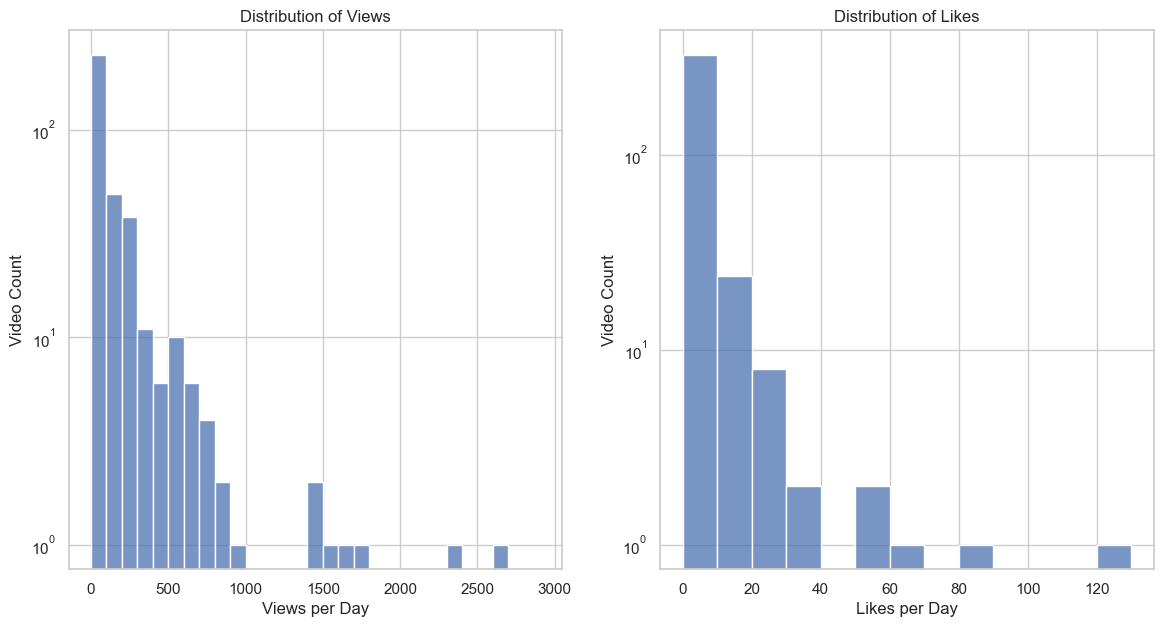

In [22]:
# Distribution of views and likes
fig, axes = plt.subplots(1,2,figsize=(14,7))

sns.histplot(df['views_per_day'], bins=np.arange(0,3000,100), ax=axes[0]) # type: ignore
axes[0].set_title("Distribution of Views")
axes[0].set_xlabel('Views per Day')
axes[0].set_ylabel('Video Count')
axes[0].set_yscale('log')


sns.histplot(df['likes_per_day'], bins=np.arange(0,131,10), ax=axes[1]) # type: ignore
axes[1].set_title("Distribution of Likes")
axes[1].set_xlabel('Likes per Day')
axes[1].set_ylabel('Video Count')
axes[1].set_yscale('log')

#### Interpretation:
- **Majority of Low Views per Day and Low Likes per Day**: A substantial portion of the data points fall into the lowest view and likes categories.

- **Decreasing Frequency**: As the number of views per day and likes per day increases, the frequency of items with that many views and likes rapidly decreases.

- **Rare High Performers**: Only a very small number of items achieve high view and like counts. For instance, there are only a handful of items with views between 500 and 1000 per day, and likes between 20 and 40 per day.

### Viewership Analysis

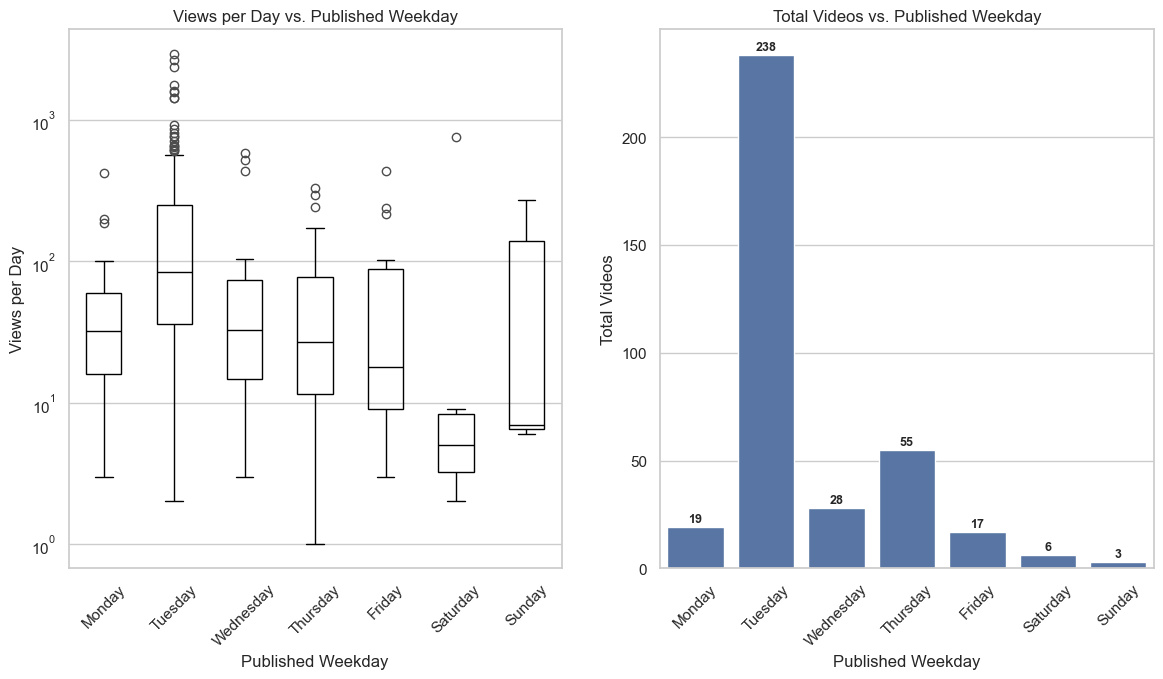

In [23]:
fig, axes = plt.subplots(1,2,figsize = (14,7))

# Boxplot of views by weekday
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(x='published_weekday', y='views_per_day', data=df, order = weekday, showfliers=True, width=0.5,ax=axes[0], 
            boxprops=dict(facecolor='none', edgecolor='black'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))
axes[0].set_ylabel('Views per Day')
axes[0].set_yscale('log')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('Published Weekday')
axes[0].set_title("Views per Day vs. Published Weekday")


# Barplot of the views distribution along weekday
sns.countplot(x='published_weekday', data=df, order=weekday, ax=axes[1])
for p in axes[1].patches:
    count = int(p.get_height())
    axes[1].text(p.get_x() + p.get_width() / 2,
                 p.get_height() + 1,
                 str(count),
                 ha='center', va='bottom', fontsize=9, fontweight='bold')

axes[1].set_ylabel('Total Videos')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xlabel('Published Weekday')
axes[1].set_title("Total Videos vs. Published Weekday")
plt.show()

**Insights**: 
- Tuesday videos tend to perform more consistently well. 
- Monday, Wednesday and Thursday all have a high median.
- Saturday is consistently underperforming.
- Sunday performs better than Saturday, but still has a low median views.

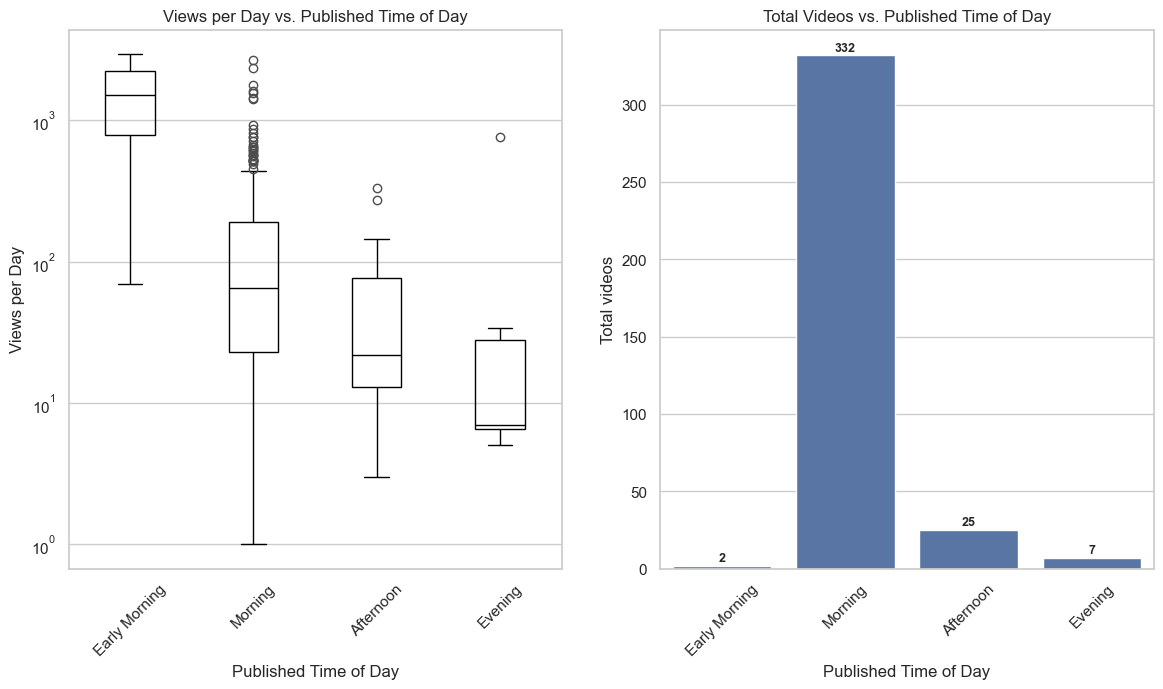

In [24]:
fig, axes = plt.subplots(1,2,figsize = (14,7))

time_of_day=['Early Morning', 'Morning', 'Afternoon', 'Evening']

# Distribution of  views per day by time of day
sns.boxplot(x='published_time_of_day', y='views_per_day', data=df, order=time_of_day, width=0.4, ax=axes[0],
            boxprops=dict(facecolor='none', edgecolor='black'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))

axes[0].set_ylabel('Views per Day')
axes[0].set_yscale('log')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('Published Time of Day')
axes[0].set_title("Views per Day vs. Published Time of Day")



# Barplot of the views distribution along weekday
sns.countplot(x='published_time_of_day', data=df, order=time_of_day, ax=axes[1])

for p in axes[1].patches:
    count = int(p.get_height())
    axes[1].text(p.get_x() + p.get_width() / 2,
                 p.get_height() + 1,
                 str(count),
                 ha='center', va='bottom', fontsize=9, fontweight='bold')
    


axes[1].set_ylabel('Total videos')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xlabel('Published Time of Day')
axes[1].set_title("Total Videos vs. Published Time of Day")
plt.show()


### Engagement Analysis

Text(0.5, 1.0, 'Likes per Day vs. Published Day of Time')

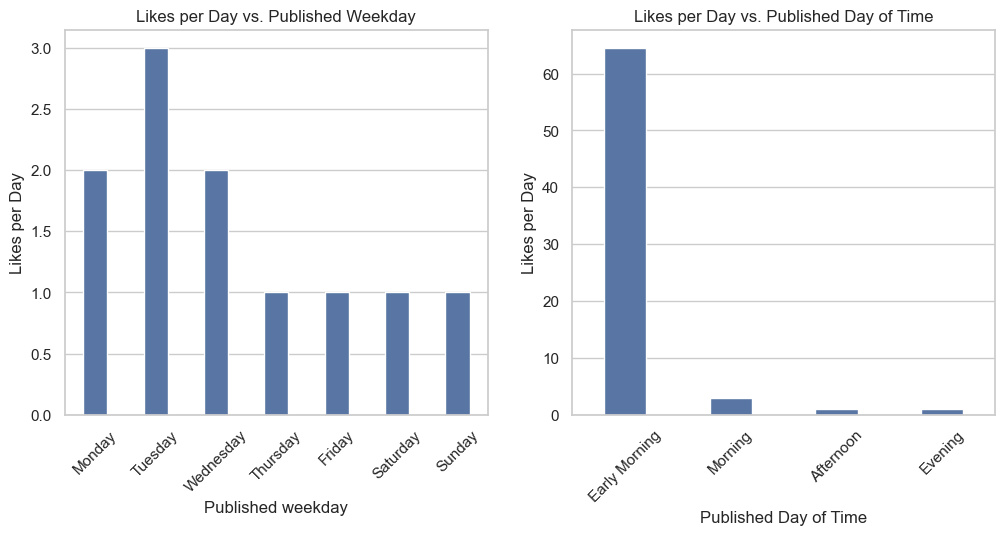

In [25]:
fig, axes = plt.subplots(1,2,figsize = (12,5))

# Boxplot of views by weekday
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x='published_weekday', y='likes_per_day', data=df, order=weekday, estimator='median', errorbar=None, width=0.4, ax=axes[0])

axes[0].set_ylabel('Likes per Day')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('Published weekday')
axes[0].set_title("Likes per Day vs. Published Weekday")


time_of_day=['Early Morning', 'Morning', 'Afternoon', 'Evening']

# Distribution of  views per day by time of day
sns.barplot(x='published_time_of_day', y='likes_per_day', data=df, order=time_of_day, estimator='median', errorbar=None, width=0.4, ax=axes[1])
            
axes[1].set_ylabel('Likes per Day')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xlabel('Published Day of Time')
axes[1].set_title("Likes per Day vs. Published Day of Time")

### Performance by Video Duration

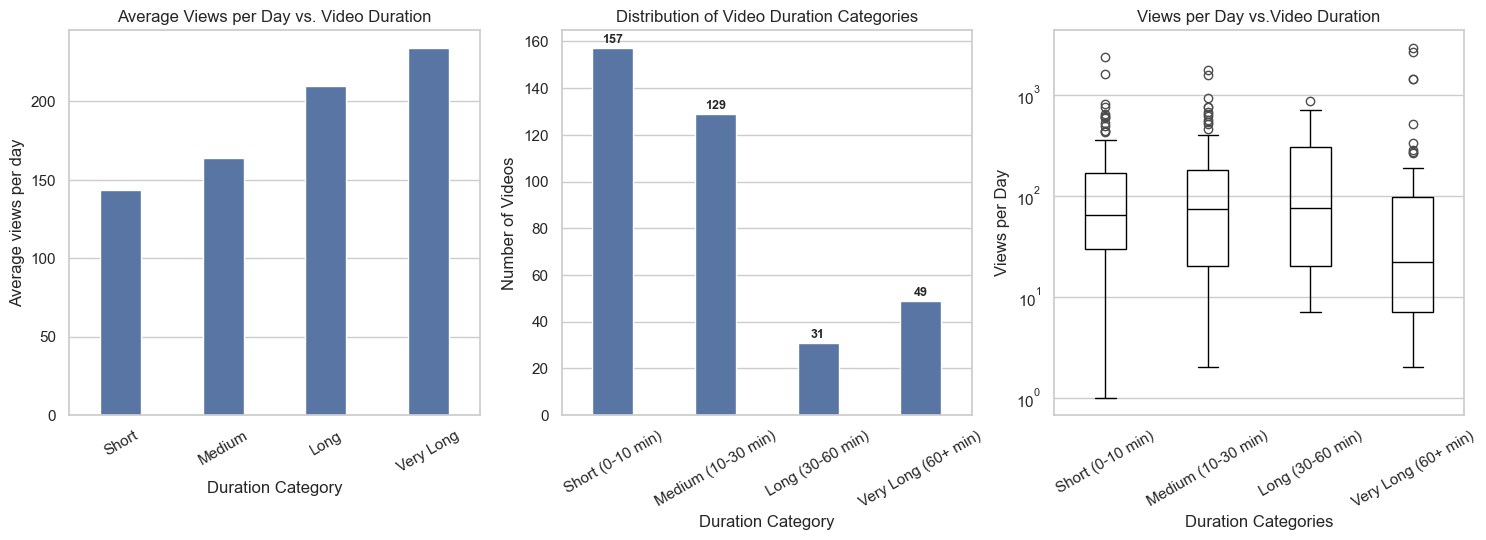

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))


sns.barplot(x='duration_bucket', y='views_per_day', data=df, estimator='mean', errorbar=None, width=0.4, ax=axes[0])
axes[0].set_title('Average Views per Day vs. Video Duration')
axes[0].set_xlabel('Duration Category')
axes[0].set_ylabel('Average views per day')
axes[0].tick_params(axis='x', rotation=30)


# Define duration buckets
df['duration_bucket'] = pd.cut(
    df['duration_seconds'],
    bins=[0, 600, 1800, 3600, 100000],
    labels=['Short (0-10 min)', 'Medium (10-30 min)', 'Long (30-60 min)', 'Very Long (60+ min)'],
    right=False
)

# Plot duration distribution
sns.countplot(x='duration_bucket', data=df, ax=axes[1], width=0.4)  # Use countplot for category frequencies

for p in axes[1].patches:
    count = int(p.get_height())
    axes[1].text(p.get_x() + p.get_width() / 2,
                 p.get_height() + 1,
                 str(count),
                 ha='center', va='bottom', fontsize=9, fontweight='bold')    

axes[1].set_title("Distribution of Video Duration Categories")
axes[1].set_xlabel("Duration Category")
axes[1].set_ylabel("Number of Videos")
axes[1].tick_params(axis='x', rotation=30)

# Like ratio vs duration
sns.boxplot(x='duration_bucket', y='views_per_day', data=df, width=0.4, ax=axes[2],
            boxprops=dict(facecolor='none', edgecolor='black'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))
axes[2].set_yscale('log')
axes[2].set_xlabel('Duration Categories')
axes[2].set_ylabel('Views per Day')
axes[2].tick_params(axis='x',rotation=30)
axes[2].set_title('Views per Day vs.Video Duration')
plt.show()


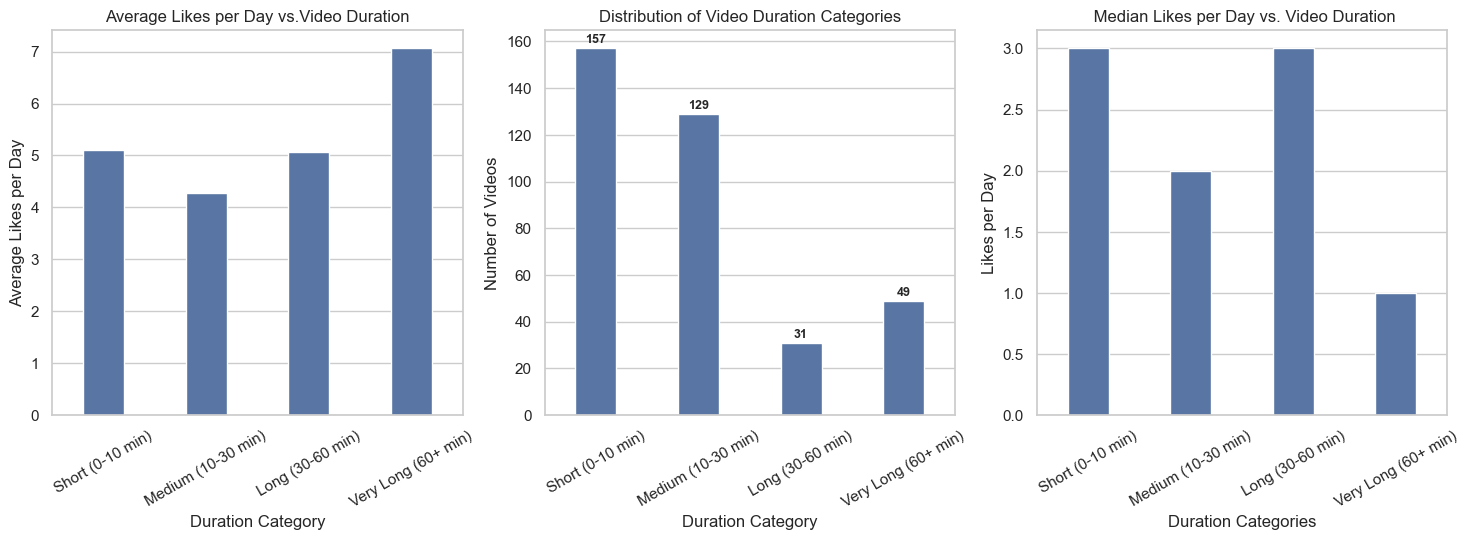

In [27]:
fig, axes=plt.subplots(1,3,figsize=(18,5))

sns.barplot(x='duration_bucket', y='likes_per_day', data=df, estimator='mean', errorbar=None,width=0.4, ax=axes[0])
axes[0].set_title('Average Likes per Day vs.Video Duration')
axes[0].set_xlabel('Duration Category')
axes[0].set_ylabel('Average Likes per Day')
axes[0].tick_params(axis='x', rotation=30)

# Plot duration distribution
sns.countplot(x='duration_bucket', data=df, ax=axes[1], width=0.4)  # Use countplot for category frequencies

for p in axes[1].patches:
    count = int(p.get_height())
    axes[1].text(p.get_x() + p.get_width() / 2,
                 p.get_height() + 1,
                 str(count),
                 ha='center', va='bottom', fontsize=9, fontweight='bold')    

axes[1].set_title("Distribution of Video Duration Categories")
axes[1].set_xlabel("Duration Category")
axes[1].set_ylabel("Number of Videos")
axes[1].tick_params(axis='x', rotation=30)


sns.barplot(x='duration_bucket', y='likes_per_day', data=df, estimator='median', errorbar=None, width=0.4, ax=axes[2])
axes[2].set_xlabel('Duration Categories')
axes[2].set_ylabel('Likes per Day')
axes[2].tick_params(axis='x', rotation=30)
axes[2].set_title(" Median Likes per Day vs. Video Duration")
plt.show()

### Performance by Topic Content

Text(0, 0.5, 'Category')

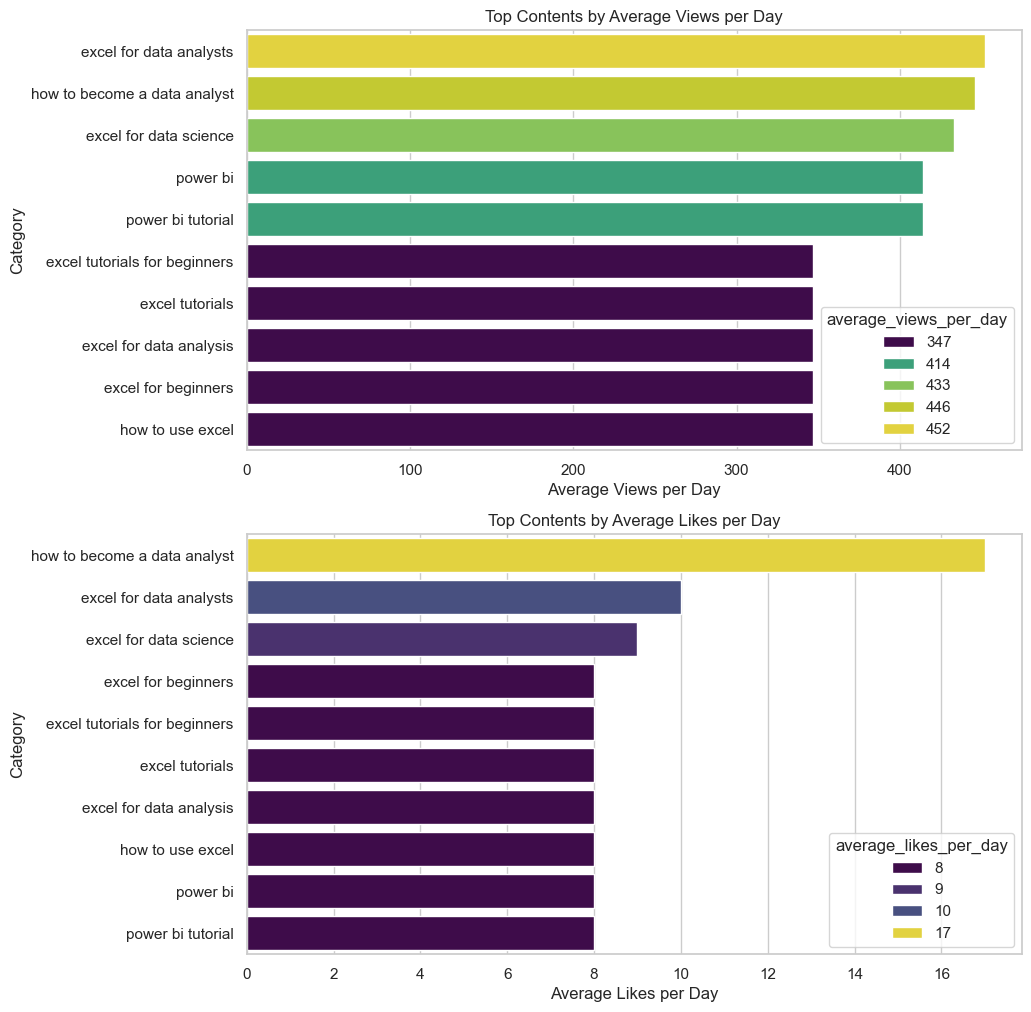

In [30]:
fig, axes = plt.subplots(2,1,figsize=(10, 12))

top_tags_views = tag_stats_filtered.sort_values('average_views_per_day', ascending=False).head(10)
top_tags_views['average_views_per_day'] = top_tags_views['average_views_per_day'].round().astype(int)

sns.barplot(data=top_tags_views, x='average_views_per_day', y='tag', hue='average_views_per_day', palette='viridis', ax = axes[0])
axes[0].set_title("Top Contents by Average Views per Day")
axes[0].set_xlabel("Average Views per Day")
axes[0].set_ylabel("Category")



top_tags_likes = tag_stats_filtered.sort_values('average_likes_per_day', ascending=False).head(10)
top_tags_likes['average_likes_per_day'] = top_tags_likes['average_likes_per_day'].round().astype(int)

sns.barplot(data=top_tags_likes, x='average_likes_per_day', y='tag', hue='average_likes_per_day', palette='viridis',  ax = axes[1])
axes[1].set_title("Top Contents by Average Likes per Day")
axes[1].set_xlabel("Average Likes per Day")
axes[1].set_ylabel("Category")
